# Pretraining on Unlabeled Data

In [1]:
from importlib.metadata import version

packages = ["numpy",
            "matplotlib",
            "tiktoken",
            "torch",
            "tensorflow"    # use for OpenAI's pretrained weights
            ]

for package in packages:
    try:
        pkg_version = version(package)
    except Exception as e:
        pkg_version = f"Error retrieving version: {e}"
    print(f"{package}: {pkg_version}")

numpy: 2.1.3
matplotlib: 3.10.0
tiktoken: 0.12.0
torch: 2.4.1
tensorflow: 2.20.0


- LLM pretraining을 위한 training loop와 기본적인 model evaluation code를 구현하는 것을 목표로 함.
- 후에는 OpenAI에서 제공하는 open된 pretrained weight를 구현한 model에 load 해보는 것을 목표로 함.


![overall](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/01.webp)


- 현재 chapter에서 구현하고자 하는 내용은 아래와 같음.

![stage](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/02.webp)

## Evaluating generative text models

- 이전 chapter에서 작성했던 code를 사용, GPT model을 initialize 하는 과정을 간략히 recap.
- 이후엔 LLM에 사용되는 basic evaluation metric을 살펴보고, training & validation dataset에 대해 이 evaluation metric을 적용해보는 것을 목표로 함.

### Using GPT to generate text

- 이전 chatper에서 다음과 같이 GPT model을 초기화 했었음.

In [2]:
import torch
from _05_previous_modules import GPTModel

GPT_CONFIG_124M = {
    'vocab_size': 50257,        # Vocabulary size
    'context_length': 256,      # Context(max sequence) length
    'embed_dim': 768,           # Embedding dimension
    'num_heads': 12,            # Number of attention heads
    'num_layers': 12,           # Number of layers(transformer blocks)
    'drop_rate': 0.1,           # Dropout rate
    'qkv_bias': False,          # Q,K,V bias
}

torch.manual_seed(62)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
  )
  (final_norm): Layer

- 현재 dropout을 0.1로 사용했지만, **최근에는 dropout 없이 LLM을 train하는 것이 일반적**임.
- 이전 GPT model과 달리, **최신 LLM model들은 Q,K,V matrix에 대해 `nn.Linear`에서 bias vector를 사용하지 않음**.  <br>
  (`"qkv_bias": False`로 설정할 수 있음.)
- model training에 필요한 computation resource를 줄이기 위해 `context_length`를 256개의 toekn으로 줄였음.  <br>
  (기존 124M을 사용하는 GPT-2 model은 1024개의 token을 사용함.)
    - 각자의 컴퓨터 환경이 다르므로, 일부러 줄인 것이라고 함. (from original code)
    - 나중에 pretrained weight를 이용해 `context_length`가 1024인 model을 load 할 예정.

- 이전 chapter에서 사용했던 `generate_text_simple` 함수를 사용해서 text를 생성할 것임.  <br>
  (original code는 이를 사용했지만, 여기선 응용 & 편의상 KV-cache를 사용했던 version을 사용할 예정.)
- 또한 사용할 token-text representation 간의 변환을 위해 `text_to_token_ids`와 `token_ids_to_text`를 정의할 것임.
- 전체적인 flow를 보면 다음과 같음.

![text generation](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/03.webp)

In [3]:
import tiktoken
from _05_previous_modules import generate_text_simple_cached

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    token_ids_list = token_ids.squeeze(0)  # Remove batch dimension
    text = tokenizer.decode(token_ids_list.tolist())
    return text

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple_cached(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M['context_length']
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you>: processingureenHR Hole condo firearm Tueshare上


- 현재 model은 train이 되지 않았으므로, 양질의 text를 생성하지 않고 무작위 text를 생성함.
- 그렇다면, training 과정에서 "good text(양질의 text)"를 수치 형태로 측정하거나 포착하는 방법은 무엇이 있을까?
- 이후 section에선 training 상황을 측정하는데 사용할 수 있는, 생성된 ouput에 대한 loss를 계산하기 위한 metric을 살펴볼 것.

### Calculating the text generation loss: Cross-Entropy and Perplexity

- `inputs` tensor에 2개의 training example(row)에 대한 token ID가 포함되어 있다고 가정.
- `inputs`에 대응하여, `targets`에는 model이 생성하기를 원하는 token ID가 포함되어 있음.
  - 이때, `targets`는 `inputs`를 한 칸 이동(shift by 1 position)한 값임을 유의. 

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- model에 `inputs`를 제공하면, 각각 3개의 token으로 구성된 2개의 input example에 대한 logit vector를 얻을 수 있음.
  - 이때 각 token은 `vocab_size`에 해당하는 50,257 차원의 vector.
- softmax 함수를 적용하면, logit tensor를 probability score(확률값)으로 이뤄진 동일한 차원의 tensor로 변환할 수 있음.

In [5]:
with torch.no_grad():
    logits = model(inputs)

print("Logits shape:", logits.shape)        # Expected: (2, 3, vocab_size)

proba = torch.softmax(logits, dim=-1)       # Probability of each token in vocabulary
print("Probabilities shape:", proba.shape)  # Expected: (2, 3, vocab_size)

Logits shape: torch.Size([2, 3, 50257])
Probabilities shape: torch.Size([2, 3, 50257])


- 하단의 그림은 simple한 vocab를 사용해, 확률값을 text로 다시 변환하는 과정을 보여줌.

![prob_to_text](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/04.webp)


- 이전 chapter에서 다뤘듯, `argmax`함수를 이용해 확률값을 예측하고자 하는 token ID로 변환할 수 있음.
- softmax 함수는 각 token에 대해 50,257 차원의 vector를 생성함.  <br>
  이때, `argmax`함수는 이 vector에서 가장 높은 확률 값을 갖는 위치를 return함.  <br>
  $\rightarrow$ 이것이 바로 주어진 token에 대해 예측된 token ID.


- 입력 batch가 각각 3개의 token으로 구성된 2개 이므로, (2, 3) 크기의 예측된 token ID를 얻을 수 있음.

In [6]:
token_ids = torch.argmax(proba, dim=-1, keepdim=True)
print("Token IDs: \n", token_ids)

Token IDs: 
 tensor([[[48800],
         [ 9753],
         [47199]],

        [[25414],
         [26565],
         [18679]]])


- 이 token들을 decode 해보면, model이 predict하길 원하는 token(target token)과는 상당히 다르다는 것을 알 수 있음.

In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Presumably roof pies


- 당연히 현재 model이 아직 train되지 않았기 때문임.
- model을 train하기 위해선, 현재 값이 정확한 예측(target)값과 얼마나 차이가 나는지를 알아야 함.

![predict](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/06.webp)

- 현재 target index에 해당하는 token probability는 다음과 같음:

In [8]:
text_idx = 0
target_probas_1 = proba[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = proba[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([1.7427e-05, 2.5237e-05, 1.4334e-05])
Text 2: tensor([4.0717e-06, 1.1408e-05, 9.1311e-06])


- 목표는 이 모든 값들을 maximize해서, 확률이 1에 가까워 지도록 하는 것.
- 수학적으로 볼때, 확률값을 최대화 한다는 것은 확률 점수의 log값을 최대화 하는 것이 더욱 쉽고 간편한 접근.  <br>
  (optimization 관련 내용, 자세한 내용은 [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM) 를 참고.)

In [9]:
# 모든 token 확률의 log값을 계산
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# log 확률의 평균을 계산
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor([-10.9575, -10.5872, -11.1529, -12.4115, -11.3812, -11.6038])
tensor(-11.3490)


- 목표는 model의 weight를 최적화 해서, 이 **average log-probality를 가능한 크게** 만드는 것.
- log변환을 했기에 가능한 최대값은 0이고, 현재 값은 0에서 상당이 멀리 떨어져 있음.


- 일반적으로, 딥러닝에서는 average log-probablity를 최대화 하지 않고, **negative average log-proability를 최소화** 하는 것이 일반적.
  - 현재 경우에서 생각해보면, -11.1729를 최대화해서 0에 가깝게 만드는 대신, 11.1792를 최소화해서 0에 가깝게 만드는 것.
  - -11.1729의 읍수값, 11.1729은 딥러닝에서 cross-entropy loss라고도 함.

In [10]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(11.3490)


- 마찬가지로, PyTorch는 `cross_entropy` 함수가 구현이 되어 있음.

![CELoss](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/07.webp)


- `cross_entropy` 함수를 적용하기 전, logit과 target의 shape를 확인해보면 다음과 같음.

In [11]:
# Logits shape: (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets shape: (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- PyTorch의 `cross_entropy` 함수는 이러한 tensor들을 batch 차원을 기준으로 결합해 flatten함.

In [12]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 여기서 target은 token ID이고, 이는 최대화하고자 하는 logit tensor의 index 위치를 나타냄.
- PyTorch의 `cross_entropy` 함수는 최대화 할 logit의 token index에 대해 softmax 및 log-probability의 계산을 내부적으로 자동으로 계산함.

In [13]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross-entropy loss:", loss)

Cross-entropy loss: tensor(11.3490)


- Cross-entropy loss와 관련된 개념 중 하는 LLM의 perplexity.
  - 단순히 cross-entropy loss에 exponential을 취한 값.

In [14]:
perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Perplexity: tensor(84880.2031)


- perplexity는 cross-entropy loss보다 더 해석 가능(interpretable)하다고 여겨지는데, 이는 model이 각 step에서 불확실성을 가지는 효과적인 vocab size로 이해될 수 있기 때문. (현재 예시는 48,725개의 word 또는 token에 해당)  <br>
  (*The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens)*)
- 즉, perplexity는 **model이 예측한 확률 분포가 dataset에 있는 word의 실제 분포와 얼마나 잘 일치하는지를 측정**하는 지표.
- loss와 마찬가지로, **낮은 perplexity 값은 model의 예측이 실제 분포에 더 가깝다는 것을 의미**함.

### Calculating the training and validation set losses

- LLM training에 비교적 작은 dataset(단편 소설)을 사용할 것. (from chapter 02)
- 이것을 사용하는 이유는 다음과 같음: (from original code)
  - 적절한 GPU가 없는 노트북에서도 몇 분 안에 code를 실행할 수 있기 때문.
  - training이 비교적 빠르게(몇 주가 아닌 몇 분만에) 끝나기 때문에 educational purpose에 적절함.
  - 저작권 침해나 저장소 크기 증가 없이 GitHub 저장소에 포함될 수 있는 공개된 domain text를 사용.
- 예시로, Llama 2 7B는 2 trillion (2조)개의 token을 학습하는데 A100 GPU에서 184,320 GPU hour가 필요했음.
  - AWS A100 클라우드 서버 8대를 시간당 사용하는 것은 약 $30, 따라서 간단한 계산으로 이 LLM을 train하는데 드는 비용은 184,320 / 8 * $30 = $690,000 임.

In [15]:
text_path = '../01.Low-level implementation/the-verdict.txt'

with open(text_path, 'r', encoding='utf-8') as f:
    text_data = f.read()

print(text_data[:99])
print("================="*5)

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Total characters:", total_characters)
print("Total tokens:", total_tokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
Total characters: 20479
Total tokens: 5145


- 앞서 언급햇듯, 5,145개의 token은 LLM을 train하기엔 터무니 없이 짧은 길이. (어디까지나 educational purpose)
- dataset을 load했으므로, train set과 validation set으로 나눠서 LLM training을 위한 batch를 준비.

![batch data](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/09.webp)

- 위 그림은 이해를 위한 그림으로, `max_length=6`으로 가정한 상황. 
  - 구현시, train loader의 경우 `max_length`는 LLM이 지원하는 context 길이와 동일하게 설정함.
- 요구되는 computational resource를 줄이기 위해, 작은 batch size를 사용함.
  - 그리고 애초에 dataset 자체가 작기 때문.
  - Llama2 7B의 경우 batch size는 1024.

In [16]:
from _05_previous_modules import create_dataloader_v1

# Train/Valid split
split_ratio = 0.9
split_idx = int(split_ratio * len(text_data))
train_data = text_data[:split_idx]
valid_data = text_data[split_idx:]

torch.manual_seed(62)

train_loader = create_dataloader_v1(
    text = train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

valid_loader = create_dataloader_v1(
    text = valid_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M['context_length'],
    stride = GPT_CONFIG_124M['context_length'],
    drop_last = False,
    shuffle = False,
    num_workers = 0
)

# 정상성 check
if total_tokens * (split_ratio) < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1 - split_ratio) < GPT_CONFIG_124M['context_length']:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

# 제대로 load 되었는지 확인
print("Train loader:")
for x, y in train_loader:
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)

print("\nValidation loader:")
for x, y in valid_loader:
    print("Input shape:", x.shape)
    print("Target shape:", y.shape)

# 제대로 load 되었는지 확인 (2)
print("================="*5)

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in valid_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Train loader:
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])

Validation loader:
Input shape: torch.Size([2, 256])
Target shape: torch.Size([2, 256])
Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 이어서, 주어진 batch에 대해 cross-entropy를 계산하는 function을 작성.
- 또한, 지정한 batch 수에 따른 dataloader의 loss를 계산하는 function을 작성.

In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)

    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0

    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # dataloader의 총 batch수와 일치하도록 batch 수를 reduce
        # 즉, num_batches가 dataloader의 batch 수를 초과하는 경우.
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            batch_loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += batch_loss.item()
        else:
            break
    
    avg_loss = total_loss / num_batches

    return avg_loss

- CPU/GPU에 따른 device 설정을 다음과 같이 할 수 있음.
  - 성능 좋은 어지간한 GPU는 CUDA support를 하고, VRAM 또한 여유로우므로 cuda 로 잡힘.
- 굳이 이렇게 handling 하는 이유는, data가 LLM model과 동일한 device에 확실하게 load 되도록 하기 위함.
- 지금까지의 flow를 보면 아래와 같음.

![train_val_loss](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/10.webp)

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")

elif torch.backends.mps.is_available():
    # Pytoch 2.9 또는 newer에서 지원 (stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device : {device}")

model.to(device)


torch.manual_seed(62)

# 아직 training step이 아니므로 단순 확인용.
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(valid_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using device : cuda
Training loss: 10.989358160230848
Validation loss: 10.99073600769043


## Training an LLM

- 이 section에선 간단한 training function에 초점을 맞춤.
  - learning rate warm up, cosine annealing, gradient clipping 처럼 training을 효율적으로 하는 과정은 [Appendix D: Adding Bells and Whistles to the Training Loop](https://github.com/rasbt/LLMs-from-scratch/tree/82010e2c7729c4582afd5cb155c9d654f62ba43a/appendix-D)를 참조.

![training](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/11.webp)

In [21]:
from tqdm import tqdm

def train_model_simple(model, train_loader, valid_loader, optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    
    # loss 및 확인된 token을 track하기 위한 list 초기화
    train_losses, val_losses, track_token_seen, = [], [], []
    tokens_seen, global_step = 0, -1

    # training loop
    for epoch in tqdm(range(num_epochs)):
        # training mode
        model.train()

        for input_batch, target_batch in train_loader:
            # 이전 batch iteration에서의 loss 초기화
            optimizer.zero_grad()

            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # gradient 계산
            loss.backward()

            # gradient를 이용한 model weight update
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # evaluation
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,
                    train_loader,
                    valid_loader,
                    device,
                    eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seen.append(tokens_seen)

                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        # epoch 마다 sample text를 print
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_token_seen


def evaluate_model(model, train_loader, valid_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(valid_loader, model, device, num_batches=eval_iter)
    
    model.train()

    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()

    context_size = model.position_embedding.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple_cached(
            model = model,
            idx = encoded,
            max_new_tokens = 50,
            context_size = context_size
        )
    
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace('\n', ' '))
    model.train()


In [22]:
torch.manual_seed(62)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 25
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, valid_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 (Step 000000): Train loss 10.016, Val loss 10.087
Epoch 1 (Step 000005): Train loss 8.112, Val loss 8.415


  4%|▍         | 1/25 [03:50<1:32:02, 230.12s/it]

Every effort moves you.                                                 
Epoch 2 (Step 000010): Train loss 6.682, Val loss 7.121
Epoch 2 (Step 000015): Train loss 6.030, Val loss 6.599


  8%|▊         | 2/25 [07:21<1:23:57, 219.00s/it]

Every effort moves you, the, the, the, the the the the, the, the, the, the, the the the, the.         ", the, the, the, the the, the, the the
Epoch 3 (Step 000020): Train loss 14.434, Val loss 15.204
Epoch 3 (Step 000025): Train loss 5.745, Val loss 6.431


 12%|█▏        | 3/25 [10:53<1:19:05, 215.72s/it]

Every effort moves you know, and, and, and.                                          
Epoch 4 (Step 000030): Train loss 5.271, Val loss 6.558
Epoch 4 (Step 000035): Train loss 4.754, Val loss 6.395


 16%|█▌        | 4/25 [14:31<1:15:50, 216.68s/it]

Every effort moves you.            "I't--II               ", I had the he was a little. Gisburn he was a
Epoch 5 (Step 000040): Train loss 4.237, Val loss 6.261


 20%|██        | 5/25 [17:45<1:09:35, 208.75s/it]

Every effort moves you of the of the of the of the a little a little a little of the of the he had been of the he had been. Gisburn, and I felt, as his pictures--the of the he had been of the he was,
Epoch 6 (Step 000045): Train loss 4.350, Val loss 6.231
Epoch 6 (Step 000050): Train loss 3.286, Val loss 6.187


 24%|██▍       | 6/25 [21:29<1:07:43, 213.86s/it]

Every effort moves you know to see the." "I didn't--and the picture--I didn't--I didn't to me to the Riv, and he was not his pictures--and his pictures--the, and I had been the he was a little
Epoch 7 (Step 000055): Train loss 3.091, Val loss 6.196
Epoch 7 (Step 000060): Train loss 2.663, Val loss 6.196


 28%|██▊       | 7/25 [25:22<1:06:00, 220.03s/it]

Every effort moves you know to see the picture--I glanced to have the fact, and in a little: "Yes, and up, I had been to me. It was his pictures--his his pictures--the, and up the "strong, and in his
Epoch 8 (Step 000065): Train loss 2.206, Val loss 6.240
Epoch 8 (Step 000070): Train loss 1.742, Val loss 6.268


 32%|███▏      | 8/25 [28:45<1:00:49, 214.66s/it]

Every effort moves you know," was not that my hostess was "interesting": on the last in the house." "I turned, I felt to see a smile, the a _not_ his pictures--the, the donkey. "strong the hour. 
Epoch 9 (Step 000075): Train loss 1.358, Val loss 6.275
Epoch 9 (Step 000080): Train loss 1.157, Val loss 6.297


 36%|███▌      | 9/25 [32:12<56:34, 212.13s/it]  

Every effort moves you know," was not that my hostess was "interesting": on the background of the house." "I turned, I felt to see a smile behind his close grayish beard--as if he had the donkey. "strongest," I found
Epoch 10 (Step 000085): Train loss 0.892, Val loss 6.393


 40%|████      | 10/25 [35:31<52:04, 208.29s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him. Gisburn's an awful simpleton, and muddling; and his glory, he had dropped his painting, had been the man of the hour. The
Epoch 11 (Step 000090): Train loss 0.642, Val loss 6.405
Epoch 11 (Step 000095): Train loss 0.492, Val loss 6.545


 44%|████▍     | 11/25 [39:15<49:41, 212.93s/it]

Every effort moves you?"        He the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 12 (Step 000100): Train loss 0.356, Val loss 6.590
Epoch 12 (Step 000105): Train loss 0.272, Val loss 6.635


 48%|████▊     | 12/25 [42:51<46:19, 213.82s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--she's an awful simpleton, and muddling; then I looked at the donkey again. I may be pardoned the bull--ah, and
Epoch 13 (Step 000110): Train loss 0.245, Val loss 6.682
Epoch 13 (Step 000115): Train loss 0.193, Val loss 6.800


 52%|█████▏    | 13/25 [45:48<40:34, 202.89s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 14 (Step 000120): Train loss 0.158, Val loss 6.829
Epoch 14 (Step 000125): Train loss 0.168, Val loss 6.884


 56%|█████▌    | 14/25 [48:38<35:21, 192.87s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 15 (Step 000130): Train loss 0.149, Val loss 6.970


 60%|██████    | 15/25 [51:07<29:56, 179.62s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 16 (Step 000135): Train loss 0.114, Val loss 6.988
Epoch 16 (Step 000140): Train loss 0.100, Val loss 7.029


 64%|██████▍   | 16/25 [53:58<26:32, 176.93s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 17 (Step 000145): Train loss 0.092, Val loss 7.063
Epoch 17 (Step 000150): Train loss 0.091, Val loss 7.074


 68%|██████▊   | 17/25 [56:48<23:18, 174.86s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 18 (Step 000155): Train loss 0.086, Val loss 7.072
Epoch 18 (Step 000160): Train loss 0.079, Val loss 7.161


 72%|███████▏  | 18/25 [59:38<20:14, 173.55s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 19 (Step 000165): Train loss 0.059, Val loss 7.144
Epoch 19 (Step 000170): Train loss 0.062, Val loss 7.231


 76%|███████▌  | 19/25 [1:02:29<17:15, 172.57s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 20 (Step 000175): Train loss 0.067, Val loss 7.248


 80%|████████  | 20/25 [1:04:58<13:48, 165.62s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 21 (Step 000180): Train loss 0.069, Val loss 7.250
Epoch 21 (Step 000185): Train loss 0.058, Val loss 7.208


 84%|████████▍ | 21/25 [1:07:48<11:07, 166.91s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 22 (Step 000190): Train loss 0.060, Val loss 7.247
Epoch 22 (Step 000195): Train loss 0.052, Val loss 7.358


 88%|████████▊ | 22/25 [1:10:37<08:22, 167.63s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 23 (Step 000200): Train loss 0.033, Val loss 7.247
Epoch 23 (Step 000205): Train loss 0.035, Val loss 7.319


 92%|█████████▏| 23/25 [1:13:27<05:36, 168.30s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 24 (Step 000210): Train loss 0.039, Val loss 7.359
Epoch 24 (Step 000215): Train loss 0.027, Val loss 7.375


 96%|█████████▌| 24/25 [1:16:18<02:48, 168.99s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Epoch 25 (Step 000220): Train loss 0.027, Val loss 7.459


100%|██████████| 25/25 [1:18:47<00:00, 189.11s/it]

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"  He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I


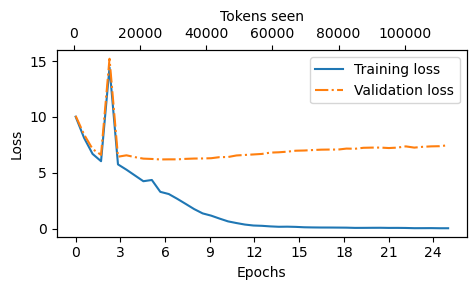

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # epoch에 따른 train/validation loss plot
    ax1.plot(epochs_seen, train_losses, label='Training loss')
    ax1.plot(epochs_seen, val_losses, linestyle='-.', label='Validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # Int label만 표시

    # tokens seen 표기를 위한 2번째 x축 표기
    ax2 = ax1.twiny()   # 같은 y축을 공유하는 2번째 x축 생성
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens seen')

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_loss(epochs_tensor, tokens_seen, train_losses, val_losses)

- 처음에는 model이 알아들을 수 없는 단어를 생성하다가, 갈수록 비교적 올바른 문장을 생성함을 알 수 있음.
- example은 10 epoch만 돌렸는데, 현재는 25 epoch.
  - 지난번엔 9 epoch에서 100m이 걸렸는데, 이번에는 왜이렇게 빨리 끝나버렸는지 이해가 가지 않음...
  - dataset 크기가 작아서, 현재 **9 epoch 이후로 overfitting**이 일어남. (val loss 증가)
  - 즉, train set에 포함되어 있는 글자가 그대로 나오고 있음. 그대로 암기하고 있다는 의미.
  - 이후에 이런 암기 효과(memorization)를 어느 정도 완화할 수 있는 decoding strategy에 대해 다룰 것.
- overfitting이 발생한 이유? **model 크기에 비해 train dataset이 너무 작고, 이를 너무 많이 반복했기 때문**.
  - 현재 구현한 LLM training은 **educational purpose** 이므로, model이 일관성 있는 텍스트를 생성할 수 있는지를 확인하는 것이 주 목표.
- LR warmup, cosine annealing, gradient clipping 과 같은 전략으로 training function을 개선하는 작업은 [Appendix D]((https://github.com/rasbt/LLMs-from-scratch/tree/main/appendix-D))를 참조.
- 더욱 큰 dataset에서의 train을 시도한다면, [bonus pretraining on gutenberg](https://github.com/rasbt/LLMs-from-scratch/tree/82010e2c7729c4582afd5cb155c9d654f62ba43a/ch05/03_bonus_pretraining_on_gutenberg)를 참조.

## Decoding strategies to control randomness

- training 한 GPT model처럼 비교적 작은 LLM을 사용하면 inference 비용은 상대적으로 저렴.
  - training에 GPU를 사용했더라도, inference에는 GPU를 사용할 필요가 굳이 없음.
- 이전에 사용한 `generate_text_simple(_cached)`를 사용하면 token 단위로 새로운 text를 생성할 수 있음.
  - 다음에 생성되는 token은 vocabulary에 있는 모든 token 중에서 확률값이 가장 높은 token.

In [28]:
inference_device = torch.device('cpu')

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple_cached(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- `generate_text_simple_cached`를 몇번 돌려도, 현재 LLM은 동일한 결과를 내놓을 것.
- 이제 이를 수정하기 위한 2가지 concept: `temperature`와 `top-k sampling`을 다룰 것.
  - 이를 통해 model은 생성되는 text의 무작위성(randomness)과 다양성(diversity)를 제어할 수 있음.

### Temperature scaling

- 현재 구현한 text 생성 함수는 `torch.argmax`를 사용해서 확률이 가낭 높은 token을 다음 token으로 sampling 했음.
- 다양성을 더하기 위해, `torch.multinomial(probs, num_samples=1)`을 사용해서 확률 분포에서 sampling하여 다음 token을 추출 할 수 있음
  - 즉, `torch.argmax`를 통해 가장 가능성이 높은 token을 선택하는 대신, `torch.multinomial(probs, num_samples=`을 통해 softmax 분포에서 sampling하여 가장 가능성이 높은 토큰을 결정할 수 있음.
- 이때, 각 index가 선택될 확률은 input tensor에서의 확률에 해당함.
- 기존의 softmax 확률을 사용해 다음 token을 1000번 sampling 하면 어떻게 되는지 보면 다음과 같음.

In [30]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)

def print_sampled_tokens(probas):
    torch.manual_seed(62)

    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))

    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print(print_sampled_tokens(probas))

55 x closer
1 x every
0 x effort
578 x forward
3 x inches
0 x moves
0 x pizza
358 x toward
5 x you
None


- **temperature scaling** 이라는 개념을 통해 distribution과 selection process를 제어할 수 있음.
  - 이는 단순히 logit 값을 0보다 큰 수로 나누는 것을 fancy 하게 나타낸 말.
- **temperature가 1보다 크면 softmax를 적용한 후 token 확률이 더욱 균일하게 분포**되고, **1보다 작으면 softmax를 적용한 후 더 확실한(confident, sharper, more peaky) 분포**가 나타남.

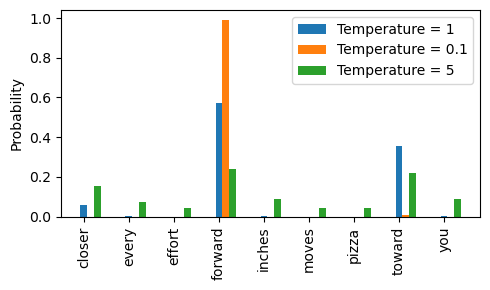

In [31]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature

    return torch.softmax(scaled_logits, dim=0)

# temperature values
    # original, higher confidence, lower confidence
temperatures = [1, 0.1, 5]

# scaled 된 확률값 계산
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

# plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

- temperature를 0.1로 설정한 rescaling은 `torch.argmax`에 근접하는 더욱 선명한 분포를 만들어내고, 가장 가능성이 높은 word(token)가 거의 항상 선택됨을 알 수있음.

In [33]:
print_sampled_tokens(scaled_probas[1])
print("================="*5)

print_sampled_tokens(scaled_probas[2])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
0 x you
159 x closer
66 x every
53 x effort
224 x forward
89 x inches
57 x moves
33 x pizza
216 x toward
103 x you


- temperature 5(lower confidence)로 설정한 경우 단어들의 조금 더 uniformly distributed 된걸 볼 수 있음.
- 입력 값이 "Every effort moves you"라고 가정할 때, 위와 같은 접근 방식을 사용하면 "Every effort moves you pizza"와 같은 의미 없는 문장이 생성될 수 있음. (1000번 중 32번, 약 3.2%)

### Top-k sampling

- output divesity를 높이고, 무의미한 문장의 발생 확률을 줄이기 위해 더 높은 값의 temperature를 사용할 수 있음.
  - 이때, sampling된 token을 발생 가능성이 가장 높은 top k개의 token으로 제한할 수 있음.

![top-k-sampling](https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/15.webp)

In [34]:
top_k = 3
top_logits, top_ops = torch.topk(next_token_logits, top_k)

print(f"Top logits: {top_logits}")
print(f"Top positions: {top_ops}")
print("================="*5)

new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)

print(new_logits)
print("================="*5)

topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Modifying the text generation function

- 앞서 살펴본 temperature, top-k sampling을 사용해 `generate_text_simple`을 수정한 새로운 함수를 작성.

In [37]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None, use_cache=True):
    """
    Decoding with temperature & top-k sampling (with KV-cache)
    """
    # For loop은 이전과 동일.
    for _ in range(max_new_tokens):
        if use_cache:
            # Initialize cache
            model.reset_kv_cache()
            idx_cond = idx[:, -context_size:]

            with torch.no_grad():
                logits = model(idx_cond, use_cache=True)
            
            logits = logits[:, -1, :]

            # Top-k sampling을 통한 logit filtering
            if top_k is not None:
                # top-k value만 유지
                top_logits, _ = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

            # temperature scaling
            if temperature > 0.0:
                logits = logits / temperature

                # softmax를 적용하기 전에 row-wise로 최대값을 substract
                logits = logits - logits.max(dim=-1, keepdim=True).values

                # softmax를 적용해서 확률값 계산
                    # [batch_size, context_length]
                probs = torch.softmax(logits, dim=-1)

                # distribution에서 sampling
                    # [batch_size, 1]
                idx_next = torch.multinomial(probs, num_samples=1)
            
            # 둘다 사용하지 않는 경우는 이전과 동일
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # sequence 마지막 token에 도달하고, eos_id가 지정된 경우 생성을 중지
            if idx_next == eos_id:
                break

            # sampled index를 sequence에 추가
            idx = torch.cat((idx, idx_next), dim=1)
        
        else:
            idx_cond = idx[:, -context_size:]

            with torch.no_grad():
                logits = model(idx_cond, use_cache=False)
            
            logits = logits[:, -1, :]

            # Top-k sampling을 통한 logit filtering
            if top_k is not None:
                # top-k value만 유지
                top_logits, _ = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

            # temperature scaling
            if temperature > 0.0:
                logits = logits / temperature

                # softmax를 적용하기 전에 row-wise로 최대값을 substract
                logits = logits - logits.max(dim=-1, keepdim=True).values

                # softmax를 적용해서 확률값 계산
                    # [batch_size, context_length]
                probs = torch.softmax(logits, dim=-1)

                # distribution에서 sampling
                    # [batch_size, 1]
                idx_next = torch.multinomial(probs, num_samples=1)
            
            # 둘다 사용하지 않는 경우는 이전과 동일
            else:
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            # sequence 마지막 token에 도달하고, eos_id가 지정된 경우 생성을 중지
            if idx_next == eos_id:
                break

            # sampled index를 sequence에 추가
            idx = torch.cat((idx, idx_next), dim=1)
    
    return idx


In [38]:
torch.manual_seed(62)

token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens = 15,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 25,
    temperature = 1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

He stood--and by me to the irony. She wanted


## Loading and saving model weights in PyTorch

- LLM을 그때그때 training 하는 것은 상당히 computationally expensive.
- 따라서, train한 LLM의 weight를 save하고 load 하는 것이 바람직 함.
- PyTorch에서 model weight, 즉 `state_dict`를 저장하는 대부분의 방법은 `torch.save(model.state_dict())`를 하는 것.

In [ ]:
torch.save(model.state_dict(), "first_GPT_124M.pth")    # 622MB

- 한번 weight를 save했다면, 다음과 같이 model weight를 새로운 GPT model instance에 load 할 수 있음.

In [43]:
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

model.load_state_dict(torch.load("first_GPT_124M.pth", map_location=device, weights_only=True))
model.eval()

Device: cuda


GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
  )
  (final_norm): Layer

- LLM train을 할 때는 일반적인 SGD보단 Adam이나 AdamW 같은 adaptive optimizer를 사용하는 것이 일반적.
- 이러한 **adaptive optimizer는 각 model weight에 대한 추가적인 parameter를 저장**하므로, **나중에 pre-training을 계속한다면 이러한 parameter들도 함께 저장**하는 것이 좋음.

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
    },
    "first_GPT_124M_with_optimizer.pth"     # 1.81GB
)

In [46]:
checkpoint = torch.load("first_GPT_124M_with_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
print(model.eval())
print(optimizer)

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(256, 768)
  (drop_embedding): Dropout(p=0.1, inplace=False)
  (transformer_blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
  )
  (final_norm): Layer

## Loading pretrained weights from OpenAI

- 앞서 educational purpose로 아주 짧은 story book을 사용해 small GPT-2 model을 train 했음.
- large pretraining corpus를 사용해서 pre-training을 위해 수십만 달러를 지출할 필요가 없이, OpenAI에서 제공하는 pre-trained weight를 불러올 수 있음.


(아래 내용은 기존 code를 사용하지 않고, [weight-loading-pytorch](https://github.com/rasbt/LLMs-from-scratch/blob/82010e2c7729c4582afd5cb155c9d654f62ba43a/ch05/02_alternative_weight_loading/weight-loading-pytorch.ipynb)를 사용함.)

In [53]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"embed_dim": 768, "num_layers": 12, "num_heads": 12},
    "gpt2-medium (355M)": {"embed_dim": 1024, "num_layers": 24, "num_heads": 16},
    "gpt2-large (774M)": {"embed_dim": 1280, "num_layers": 36, "num_heads": 20},
    "gpt2-xl (1558M)": {"embed_dim": 1600, "num_layers": 48, "num_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [49]:
file_name = "gpt2-small-124M.pth"       # 669MB
# file_name = "gpt2-medium-355M.pth"    # 약 1.3GB ~ 1.5GB
# file_name = "gpt2-large-774M.pth"     # 약 3GB ~ 5GB
# file_name = "gpt2-xl-1558M.pth"       # 약 5.8GB ~ 6GB

In [50]:
import os
import requests

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    response = requests.get(url, timeout=60)
    response.raise_for_status()

    with open(file_name, "wb") as f:
        f.write(response.content)
    
    print(f"Downloaded to {file_name}")

Downloaded to gpt2-small-124M.pth


### Load weights

In [55]:
from _05_previous_modules import GPTModel

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);

RuntimeError: Error(s) in loading state_dict for GPTModel:
	Missing key(s) in state_dict: "token_embedding.weight", "position_embedding.weight", "transformer_blocks.0.attention.mask", "transformer_blocks.0.attention.W_query.weight", "transformer_blocks.0.attention.W_query.bias", "transformer_blocks.0.attention.W_key.weight", "transformer_blocks.0.attention.W_key.bias", "transformer_blocks.0.attention.W_value.weight", "transformer_blocks.0.attention.W_value.bias", "transformer_blocks.0.attention.out_projection.weight", "transformer_blocks.0.attention.out_projection.bias", "transformer_blocks.0.ffn.layers.0.weight", "transformer_blocks.0.ffn.layers.0.bias", "transformer_blocks.0.ffn.layers.2.weight", "transformer_blocks.0.ffn.layers.2.bias", "transformer_blocks.0.norm1.scale", "transformer_blocks.0.norm1.shift", "transformer_blocks.0.norm2.scale", "transformer_blocks.0.norm2.shift", "transformer_blocks.1.attention.mask", "transformer_blocks.1.attention.W_query.weight", "transformer_blocks.1.attention.W_query.bias", "transformer_blocks.1.attention.W_key.weight", "transformer_blocks.1.attention.W_key.bias", "transformer_blocks.1.attention.W_value.weight", "transformer_blocks.1.attention.W_value.bias", "transformer_blocks.1.attention.out_projection.weight", "transformer_blocks.1.attention.out_projection.bias", "transformer_blocks.1.ffn.layers.0.weight", "transformer_blocks.1.ffn.layers.0.bias", "transformer_blocks.1.ffn.layers.2.weight", "transformer_blocks.1.ffn.layers.2.bias", "transformer_blocks.1.norm1.scale", "transformer_blocks.1.norm1.shift", "transformer_blocks.1.norm2.scale", "transformer_blocks.1.norm2.shift", "transformer_blocks.2.attention.mask", "transformer_blocks.2.attention.W_query.weight", "transformer_blocks.2.attention.W_query.bias", "transformer_blocks.2.attention.W_key.weight", "transformer_blocks.2.attention.W_key.bias", "transformer_blocks.2.attention.W_value.weight", "transformer_blocks.2.attention.W_value.bias", "transformer_blocks.2.attention.out_projection.weight", "transformer_blocks.2.attention.out_projection.bias", "transformer_blocks.2.ffn.layers.0.weight", "transformer_blocks.2.ffn.layers.0.bias", "transformer_blocks.2.ffn.layers.2.weight", "transformer_blocks.2.ffn.layers.2.bias", "transformer_blocks.2.norm1.scale", "transformer_blocks.2.norm1.shift", "transformer_blocks.2.norm2.scale", "transformer_blocks.2.norm2.shift", "transformer_blocks.3.attention.mask", "transformer_blocks.3.attention.W_query.weight", "transformer_blocks.3.attention.W_query.bias", "transformer_blocks.3.attention.W_key.weight", "transformer_blocks.3.attention.W_key.bias", "transformer_blocks.3.attention.W_value.weight", "transformer_blocks.3.attention.W_value.bias", "transformer_blocks.3.attention.out_projection.weight", "transformer_blocks.3.attention.out_projection.bias", "transformer_blocks.3.ffn.layers.0.weight", "transformer_blocks.3.ffn.layers.0.bias", "transformer_blocks.3.ffn.layers.2.weight", "transformer_blocks.3.ffn.layers.2.bias", "transformer_blocks.3.norm1.scale", "transformer_blocks.3.norm1.shift", "transformer_blocks.3.norm2.scale", "transformer_blocks.3.norm2.shift", "transformer_blocks.4.attention.mask", "transformer_blocks.4.attention.W_query.weight", "transformer_blocks.4.attention.W_query.bias", "transformer_blocks.4.attention.W_key.weight", "transformer_blocks.4.attention.W_key.bias", "transformer_blocks.4.attention.W_value.weight", "transformer_blocks.4.attention.W_value.bias", "transformer_blocks.4.attention.out_projection.weight", "transformer_blocks.4.attention.out_projection.bias", "transformer_blocks.4.ffn.layers.0.weight", "transformer_blocks.4.ffn.layers.0.bias", "transformer_blocks.4.ffn.layers.2.weight", "transformer_blocks.4.ffn.layers.2.bias", "transformer_blocks.4.norm1.scale", "transformer_blocks.4.norm1.shift", "transformer_blocks.4.norm2.scale", "transformer_blocks.4.norm2.shift", "transformer_blocks.5.attention.mask", "transformer_blocks.5.attention.W_query.weight", "transformer_blocks.5.attention.W_query.bias", "transformer_blocks.5.attention.W_key.weight", "transformer_blocks.5.attention.W_key.bias", "transformer_blocks.5.attention.W_value.weight", "transformer_blocks.5.attention.W_value.bias", "transformer_blocks.5.attention.out_projection.weight", "transformer_blocks.5.attention.out_projection.bias", "transformer_blocks.5.ffn.layers.0.weight", "transformer_blocks.5.ffn.layers.0.bias", "transformer_blocks.5.ffn.layers.2.weight", "transformer_blocks.5.ffn.layers.2.bias", "transformer_blocks.5.norm1.scale", "transformer_blocks.5.norm1.shift", "transformer_blocks.5.norm2.scale", "transformer_blocks.5.norm2.shift", "transformer_blocks.6.attention.mask", "transformer_blocks.6.attention.W_query.weight", "transformer_blocks.6.attention.W_query.bias", "transformer_blocks.6.attention.W_key.weight", "transformer_blocks.6.attention.W_key.bias", "transformer_blocks.6.attention.W_value.weight", "transformer_blocks.6.attention.W_value.bias", "transformer_blocks.6.attention.out_projection.weight", "transformer_blocks.6.attention.out_projection.bias", "transformer_blocks.6.ffn.layers.0.weight", "transformer_blocks.6.ffn.layers.0.bias", "transformer_blocks.6.ffn.layers.2.weight", "transformer_blocks.6.ffn.layers.2.bias", "transformer_blocks.6.norm1.scale", "transformer_blocks.6.norm1.shift", "transformer_blocks.6.norm2.scale", "transformer_blocks.6.norm2.shift", "transformer_blocks.7.attention.mask", "transformer_blocks.7.attention.W_query.weight", "transformer_blocks.7.attention.W_query.bias", "transformer_blocks.7.attention.W_key.weight", "transformer_blocks.7.attention.W_key.bias", "transformer_blocks.7.attention.W_value.weight", "transformer_blocks.7.attention.W_value.bias", "transformer_blocks.7.attention.out_projection.weight", "transformer_blocks.7.attention.out_projection.bias", "transformer_blocks.7.ffn.layers.0.weight", "transformer_blocks.7.ffn.layers.0.bias", "transformer_blocks.7.ffn.layers.2.weight", "transformer_blocks.7.ffn.layers.2.bias", "transformer_blocks.7.norm1.scale", "transformer_blocks.7.norm1.shift", "transformer_blocks.7.norm2.scale", "transformer_blocks.7.norm2.shift", "transformer_blocks.8.attention.mask", "transformer_blocks.8.attention.W_query.weight", "transformer_blocks.8.attention.W_query.bias", "transformer_blocks.8.attention.W_key.weight", "transformer_blocks.8.attention.W_key.bias", "transformer_blocks.8.attention.W_value.weight", "transformer_blocks.8.attention.W_value.bias", "transformer_blocks.8.attention.out_projection.weight", "transformer_blocks.8.attention.out_projection.bias", "transformer_blocks.8.ffn.layers.0.weight", "transformer_blocks.8.ffn.layers.0.bias", "transformer_blocks.8.ffn.layers.2.weight", "transformer_blocks.8.ffn.layers.2.bias", "transformer_blocks.8.norm1.scale", "transformer_blocks.8.norm1.shift", "transformer_blocks.8.norm2.scale", "transformer_blocks.8.norm2.shift", "transformer_blocks.9.attention.mask", "transformer_blocks.9.attention.W_query.weight", "transformer_blocks.9.attention.W_query.bias", "transformer_blocks.9.attention.W_key.weight", "transformer_blocks.9.attention.W_key.bias", "transformer_blocks.9.attention.W_value.weight", "transformer_blocks.9.attention.W_value.bias", "transformer_blocks.9.attention.out_projection.weight", "transformer_blocks.9.attention.out_projection.bias", "transformer_blocks.9.ffn.layers.0.weight", "transformer_blocks.9.ffn.layers.0.bias", "transformer_blocks.9.ffn.layers.2.weight", "transformer_blocks.9.ffn.layers.2.bias", "transformer_blocks.9.norm1.scale", "transformer_blocks.9.norm1.shift", "transformer_blocks.9.norm2.scale", "transformer_blocks.9.norm2.shift", "transformer_blocks.10.attention.mask", "transformer_blocks.10.attention.W_query.weight", "transformer_blocks.10.attention.W_query.bias", "transformer_blocks.10.attention.W_key.weight", "transformer_blocks.10.attention.W_key.bias", "transformer_blocks.10.attention.W_value.weight", "transformer_blocks.10.attention.W_value.bias", "transformer_blocks.10.attention.out_projection.weight", "transformer_blocks.10.attention.out_projection.bias", "transformer_blocks.10.ffn.layers.0.weight", "transformer_blocks.10.ffn.layers.0.bias", "transformer_blocks.10.ffn.layers.2.weight", "transformer_blocks.10.ffn.layers.2.bias", "transformer_blocks.10.norm1.scale", "transformer_blocks.10.norm1.shift", "transformer_blocks.10.norm2.scale", "transformer_blocks.10.norm2.shift", "transformer_blocks.11.attention.mask", "transformer_blocks.11.attention.W_query.weight", "transformer_blocks.11.attention.W_query.bias", "transformer_blocks.11.attention.W_key.weight", "transformer_blocks.11.attention.W_key.bias", "transformer_blocks.11.attention.W_value.weight", "transformer_blocks.11.attention.W_value.bias", "transformer_blocks.11.attention.out_projection.weight", "transformer_blocks.11.attention.out_projection.bias", "transformer_blocks.11.ffn.layers.0.weight", "transformer_blocks.11.ffn.layers.0.bias", "transformer_blocks.11.ffn.layers.2.weight", "transformer_blocks.11.ffn.layers.2.bias", "transformer_blocks.11.norm1.scale", "transformer_blocks.11.norm1.shift", "transformer_blocks.11.norm2.scale", "transformer_blocks.11.norm2.shift". 
	Unexpected key(s) in state_dict: "tok_emb.weight", "pos_emb.weight", "trf_blocks.0.att.mask", "trf_blocks.0.att.W_query.weight", "trf_blocks.0.att.W_query.bias", "trf_blocks.0.att.W_key.weight", "trf_blocks.0.att.W_key.bias", "trf_blocks.0.att.W_value.weight", "trf_blocks.0.att.W_value.bias", "trf_blocks.0.att.out_proj.weight", "trf_blocks.0.att.out_proj.bias", "trf_blocks.0.ff.layers.0.weight", "trf_blocks.0.ff.layers.0.bias", "trf_blocks.0.ff.layers.2.weight", "trf_blocks.0.ff.layers.2.bias", "trf_blocks.0.norm1.scale", "trf_blocks.0.norm1.shift", "trf_blocks.0.norm2.scale", "trf_blocks.0.norm2.shift", "trf_blocks.1.att.mask", "trf_blocks.1.att.W_query.weight", "trf_blocks.1.att.W_query.bias", "trf_blocks.1.att.W_key.weight", "trf_blocks.1.att.W_key.bias", "trf_blocks.1.att.W_value.weight", "trf_blocks.1.att.W_value.bias", "trf_blocks.1.att.out_proj.weight", "trf_blocks.1.att.out_proj.bias", "trf_blocks.1.ff.layers.0.weight", "trf_blocks.1.ff.layers.0.bias", "trf_blocks.1.ff.layers.2.weight", "trf_blocks.1.ff.layers.2.bias", "trf_blocks.1.norm1.scale", "trf_blocks.1.norm1.shift", "trf_blocks.1.norm2.scale", "trf_blocks.1.norm2.shift", "trf_blocks.2.att.mask", "trf_blocks.2.att.W_query.weight", "trf_blocks.2.att.W_query.bias", "trf_blocks.2.att.W_key.weight", "trf_blocks.2.att.W_key.bias", "trf_blocks.2.att.W_value.weight", "trf_blocks.2.att.W_value.bias", "trf_blocks.2.att.out_proj.weight", "trf_blocks.2.att.out_proj.bias", "trf_blocks.2.ff.layers.0.weight", "trf_blocks.2.ff.layers.0.bias", "trf_blocks.2.ff.layers.2.weight", "trf_blocks.2.ff.layers.2.bias", "trf_blocks.2.norm1.scale", "trf_blocks.2.norm1.shift", "trf_blocks.2.norm2.scale", "trf_blocks.2.norm2.shift", "trf_blocks.3.att.mask", "trf_blocks.3.att.W_query.weight", "trf_blocks.3.att.W_query.bias", "trf_blocks.3.att.W_key.weight", "trf_blocks.3.att.W_key.bias", "trf_blocks.3.att.W_value.weight", "trf_blocks.3.att.W_value.bias", "trf_blocks.3.att.out_proj.weight", "trf_blocks.3.att.out_proj.bias", "trf_blocks.3.ff.layers.0.weight", "trf_blocks.3.ff.layers.0.bias", "trf_blocks.3.ff.layers.2.weight", "trf_blocks.3.ff.layers.2.bias", "trf_blocks.3.norm1.scale", "trf_blocks.3.norm1.shift", "trf_blocks.3.norm2.scale", "trf_blocks.3.norm2.shift", "trf_blocks.4.att.mask", "trf_blocks.4.att.W_query.weight", "trf_blocks.4.att.W_query.bias", "trf_blocks.4.att.W_key.weight", "trf_blocks.4.att.W_key.bias", "trf_blocks.4.att.W_value.weight", "trf_blocks.4.att.W_value.bias", "trf_blocks.4.att.out_proj.weight", "trf_blocks.4.att.out_proj.bias", "trf_blocks.4.ff.layers.0.weight", "trf_blocks.4.ff.layers.0.bias", "trf_blocks.4.ff.layers.2.weight", "trf_blocks.4.ff.layers.2.bias", "trf_blocks.4.norm1.scale", "trf_blocks.4.norm1.shift", "trf_blocks.4.norm2.scale", "trf_blocks.4.norm2.shift", "trf_blocks.5.att.mask", "trf_blocks.5.att.W_query.weight", "trf_blocks.5.att.W_query.bias", "trf_blocks.5.att.W_key.weight", "trf_blocks.5.att.W_key.bias", "trf_blocks.5.att.W_value.weight", "trf_blocks.5.att.W_value.bias", "trf_blocks.5.att.out_proj.weight", "trf_blocks.5.att.out_proj.bias", "trf_blocks.5.ff.layers.0.weight", "trf_blocks.5.ff.layers.0.bias", "trf_blocks.5.ff.layers.2.weight", "trf_blocks.5.ff.layers.2.bias", "trf_blocks.5.norm1.scale", "trf_blocks.5.norm1.shift", "trf_blocks.5.norm2.scale", "trf_blocks.5.norm2.shift", "trf_blocks.6.att.mask", "trf_blocks.6.att.W_query.weight", "trf_blocks.6.att.W_query.bias", "trf_blocks.6.att.W_key.weight", "trf_blocks.6.att.W_key.bias", "trf_blocks.6.att.W_value.weight", "trf_blocks.6.att.W_value.bias", "trf_blocks.6.att.out_proj.weight", "trf_blocks.6.att.out_proj.bias", "trf_blocks.6.ff.layers.0.weight", "trf_blocks.6.ff.layers.0.bias", "trf_blocks.6.ff.layers.2.weight", "trf_blocks.6.ff.layers.2.bias", "trf_blocks.6.norm1.scale", "trf_blocks.6.norm1.shift", "trf_blocks.6.norm2.scale", "trf_blocks.6.norm2.shift", "trf_blocks.7.att.mask", "trf_blocks.7.att.W_query.weight", "trf_blocks.7.att.W_query.bias", "trf_blocks.7.att.W_key.weight", "trf_blocks.7.att.W_key.bias", "trf_blocks.7.att.W_value.weight", "trf_blocks.7.att.W_value.bias", "trf_blocks.7.att.out_proj.weight", "trf_blocks.7.att.out_proj.bias", "trf_blocks.7.ff.layers.0.weight", "trf_blocks.7.ff.layers.0.bias", "trf_blocks.7.ff.layers.2.weight", "trf_blocks.7.ff.layers.2.bias", "trf_blocks.7.norm1.scale", "trf_blocks.7.norm1.shift", "trf_blocks.7.norm2.scale", "trf_blocks.7.norm2.shift", "trf_blocks.8.att.mask", "trf_blocks.8.att.W_query.weight", "trf_blocks.8.att.W_query.bias", "trf_blocks.8.att.W_key.weight", "trf_blocks.8.att.W_key.bias", "trf_blocks.8.att.W_value.weight", "trf_blocks.8.att.W_value.bias", "trf_blocks.8.att.out_proj.weight", "trf_blocks.8.att.out_proj.bias", "trf_blocks.8.ff.layers.0.weight", "trf_blocks.8.ff.layers.0.bias", "trf_blocks.8.ff.layers.2.weight", "trf_blocks.8.ff.layers.2.bias", "trf_blocks.8.norm1.scale", "trf_blocks.8.norm1.shift", "trf_blocks.8.norm2.scale", "trf_blocks.8.norm2.shift", "trf_blocks.9.att.mask", "trf_blocks.9.att.W_query.weight", "trf_blocks.9.att.W_query.bias", "trf_blocks.9.att.W_key.weight", "trf_blocks.9.att.W_key.bias", "trf_blocks.9.att.W_value.weight", "trf_blocks.9.att.W_value.bias", "trf_blocks.9.att.out_proj.weight", "trf_blocks.9.att.out_proj.bias", "trf_blocks.9.ff.layers.0.weight", "trf_blocks.9.ff.layers.0.bias", "trf_blocks.9.ff.layers.2.weight", "trf_blocks.9.ff.layers.2.bias", "trf_blocks.9.norm1.scale", "trf_blocks.9.norm1.shift", "trf_blocks.9.norm2.scale", "trf_blocks.9.norm2.shift", "trf_blocks.10.att.mask", "trf_blocks.10.att.W_query.weight", "trf_blocks.10.att.W_query.bias", "trf_blocks.10.att.W_key.weight", "trf_blocks.10.att.W_key.bias", "trf_blocks.10.att.W_value.weight", "trf_blocks.10.att.W_value.bias", "trf_blocks.10.att.out_proj.weight", "trf_blocks.10.att.out_proj.bias", "trf_blocks.10.ff.layers.0.weight", "trf_blocks.10.ff.layers.0.bias", "trf_blocks.10.ff.layers.2.weight", "trf_blocks.10.ff.layers.2.bias", "trf_blocks.10.norm1.scale", "trf_blocks.10.norm1.shift", "trf_blocks.10.norm2.scale", "trf_blocks.10.norm2.shift", "trf_blocks.11.att.mask", "trf_blocks.11.att.W_query.weight", "trf_blocks.11.att.W_query.bias", "trf_blocks.11.att.W_key.weight", "trf_blocks.11.att.W_key.bias", "trf_blocks.11.att.W_value.weight", "trf_blocks.11.att.W_value.bias", "trf_blocks.11.att.out_proj.weight", "trf_blocks.11.att.out_proj.bias", "trf_blocks.11.ff.layers.0.weight", "trf_blocks.11.ff.layers.0.bias", "trf_blocks.11.ff.layers.2.weight", "trf_blocks.11.ff.layers.2.bias", "trf_blocks.11.norm1.scale", "trf_blocks.11.norm1.shift", "trf_blocks.11.norm2.scale", "trf_blocks.11.norm2.shift". 

- 공식 example code랑 현재 작성한 model간의 인자 naming 차이 때문에 loading이 안된다 ㄱ-
  - Gemini의 도움을 받아 key mapping 하고 load.

In [56]:
print(model.state_dict().keys())
print("================="*5)

checkpoint = torch.load("gpt2-small-124M.pth")
print(checkpoint.keys())

odict_keys(['token_embedding.weight', 'position_embedding.weight', 'transformer_blocks.0.attention.mask', 'transformer_blocks.0.attention.W_query.weight', 'transformer_blocks.0.attention.W_key.weight', 'transformer_blocks.0.attention.W_value.weight', 'transformer_blocks.0.attention.out_projection.weight', 'transformer_blocks.0.attention.out_projection.bias', 'transformer_blocks.0.ffn.layers.0.weight', 'transformer_blocks.0.ffn.layers.0.bias', 'transformer_blocks.0.ffn.layers.2.weight', 'transformer_blocks.0.ffn.layers.2.bias', 'transformer_blocks.0.norm1.scale', 'transformer_blocks.0.norm1.shift', 'transformer_blocks.0.norm2.scale', 'transformer_blocks.0.norm2.shift', 'transformer_blocks.1.attention.mask', 'transformer_blocks.1.attention.W_query.weight', 'transformer_blocks.1.attention.W_key.weight', 'transformer_blocks.1.attention.W_value.weight', 'transformer_blocks.1.attention.out_projection.weight', 'transformer_blocks.1.attention.out_projection.bias', 'transformer_blocks.1.ffn.lay

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1568\1162063402.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("gpt2-small-124M.pth")


odict_keys(['tok_emb.weight', 'pos_emb.weight', 'trf_blocks.0.att.mask', 'trf_blocks.0.att.W_query.weight', 'trf_blocks.0.att.W_query.bias', 'trf_blocks.0.att.W_key.weight', 'trf_blocks.0.att.W_key.bias', 'trf_blocks.0.att.W_value.weight', 'trf_blocks.0.att.W_value.bias', 'trf_blocks.0.att.out_proj.weight', 'trf_blocks.0.att.out_proj.bias', 'trf_blocks.0.ff.layers.0.weight', 'trf_blocks.0.ff.layers.0.bias', 'trf_blocks.0.ff.layers.2.weight', 'trf_blocks.0.ff.layers.2.bias', 'trf_blocks.0.norm1.scale', 'trf_blocks.0.norm1.shift', 'trf_blocks.0.norm2.scale', 'trf_blocks.0.norm2.shift', 'trf_blocks.1.att.mask', 'trf_blocks.1.att.W_query.weight', 'trf_blocks.1.att.W_query.bias', 'trf_blocks.1.att.W_key.weight', 'trf_blocks.1.att.W_key.bias', 'trf_blocks.1.att.W_value.weight', 'trf_blocks.1.att.W_value.bias', 'trf_blocks.1.att.out_proj.weight', 'trf_blocks.1.att.out_proj.bias', 'trf_blocks.1.ff.layers.0.weight', 'trf_blocks.1.ff.layers.0.bias', 'trf_blocks.1.ff.layers.2.weight', 'trf_blocks

In [69]:
import torch

# 1. 모델과 체크포인트 준비 (가정)
gpt = GPTModel(BASE_CONFIG)
checkpoint = torch.load("gpt2-small-124M.pth")

def load_pretrained_gpt2(model, checkpoint):
    new_state_dict = {}
    
    # 변환 규칙 정의 (찾을 단어: 바꿀 단어)
    replacements = {
        "tok_emb": "token_embedding",
        "pos_emb": "position_embedding",
        "trf_blocks": "transformer_blocks",
        ".att.": ".attention.",
        "out_proj": "out_projection",
        ".ff.": ".ffn.",
    }

    for key, value in checkpoint.items():
        new_key = key
        
        # 1. 규칙에 따라 이름 변경
        for old, new in replacements.items():
            new_key = new_key.replace(old, new)
        
        # 2. 내 모델에 해당 Key가 존재하는지 확인
        if new_key in model.state_dict():
            new_state_dict[new_key] = value
        else:
            # 매칭되지 않는 Key 출력 (디버깅용)
            print(f"Skipping: {key} -> {new_key} (Not found in your model)")

    # 3. 로드 (strict=False를 권장: 위에서 제외한 bias 등이 있을 수 있음)
    model.load_state_dict(new_state_dict, strict=False)
    print("\n로드 완료!")

# 실행
load_pretrained_gpt2(gpt, checkpoint)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1568\1672549393.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("gpt2-small-124M.pth")



로드 완료!


In [70]:
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);

In [71]:
gpt

GPTModel(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (drop_embedding): Dropout(p=0.0, inplace=False)
  (transformer_blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
  )
  (final_norm): LayerNo

### Text generation

In [86]:
torch.manual_seed(62)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model = gpt.to(device),
    idx = text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens = 40,
    context_size = BASE_CONFIG["context_length"],
    top_k = 1,
    temperature = 1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves on.


The first thing that comes to mind is that the government is trying to get rid of the "free market" and the "free market is bad" mantra. The government is
